This model is our most succesful one for Roseau Haricot images. We use the transefer learning and in particular the efficientnet architecture. We have to install it from the web and we use the B5 one, best compromise between speed and accuracy. We also applied a tiling strategy dividing each image in six pieces. We reached a score of 0.6189 in the test set.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

We import libraries, set the seed and the working directory.

In [ ]:
import os 

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(1234)

cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have created a folder 'Challenge2' in our drive with the dataset and the starting kit folder

In [ ]:
!unzip /content/drive/My\ Drive/Challenge2/Development_Dataset.zip #unzippare file in drive

Archive:  /content/drive/My Drive/Challenge2/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflatin

We build the generator. After some trials we have found that in this case the best was to have quite a lot of data augmentation.

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rescale=1./255, 
                                      rotation_range=180,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=180,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

We fix the dimensions of the images, we tried to keep it as big as possible to not lose features.

In [ ]:
img_h = 512 
img_w = 512 

Function of the starting kit used to read the mask images with a little modification in order to crop the images according to the tailing that we have implemented in the custom dataset function.

In [ ]:
import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path, img_area):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_img = mask_img.crop(img_area)
    
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    new_mask_arr=new_mask_arr.reshape((mask_arr.shape[0],mask_arr.shape[1],1))

    return new_mask_arr


#if __name__ == "__main__":

    # Read the example RGB mask and transform it into integer labels.

    #mask = read_rgb_mask("/content/drive/My Drive/Challenge2/starting_kit/predictions/rgb_mask_example.png")

    #np.save("/content/drive/My Drive/Challenge2/starting_kit/predictions/arr_mask_example.npy", mask)

Function to create the custom dataset where we read the images from the selected dataset. We have decided to focus ourselves on one dataset at a time (here Roseau Haricot).
In this case we have performed a tiling strategy where each original image is cutted in 6 different pieces. We have created a vector of counters where each counter change value at each calls of the function. In this way every time i call the function to extract an image to create the dataset i obtain one of the six different portions of the image. 

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'training.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'validation.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.count = np.zeros((len(self.subset_filenames),), dtype=int)

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join('/content/Development_Dataset/Training/Roseau/Haricot/Images', curr_filename + '.png'))
    
    img_arr = np.array(img)

    # Tiling
    # In this part of the code we select a portion of the image according to a counter
    # the couner is needed to go through all the image in different calls of the function 

    if(self.count[index] == 0):
      img_area = (0,0,img_h,img_w)
      
    
    if(self.count[index] == 1):
      img_area = (img_arr.shape[0]-img_h,0,img_arr.shape[0],img_w)
      
      
    if(self.count[index] == 2):
      img_area = (0,img_arr.shape[1]-img_w,img_h,img_arr.shape[1])
      
        
    if(self.count[index] == 3):
      img_area = (img_h,0,2*img_h,img_w)
      
      
    if(self.count[index] == 4):
      img_area = (img_h,img_arr.shape[1]-img_w,2*img_h,img_arr.shape[1])
      
    
    if(self.count[index] == 5):
      img_area = (img_arr.shape[0]-img_h,img_arr.shape[1]-img_w,img_arr.shape[0],img_arr.shape[1])
      
    if(self.count[index] == 5):
      self.count[index] = 0

    if(self.count[index] > 0):
      self.count[index] = self.count[index] +1

    
    img = img.crop(img_area)
    mask_arr = read_rgb_mask(os.path.join('/content/Development_Dataset/Training/Roseau/Haricot/Masks', curr_filename + '.png'),img_area)
    
    img_arr = np.array(img)

  

    #if self.which_subset == 'training':
    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    #else:
      #out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    
    

    return img_arr, np.float32(out_mask)

Here we create the two txt files with the train and validation split.

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("/content/Development_Dataset/Training/Roseau/Haricot/Images") if isfile(join("/content/Development_Dataset/Training/Roseau/Haricot/Images", f))]
for f in onlyfiles:
  f=f[:-4]
onlyfiles[:] = [f[:-4] for f in onlyfiles]
np.random.shuffle(onlyfiles)

valid_split=0.2

trainlength=int(len(onlyfiles)*(1-valid_split))

import os 
  
directory = "Roseau_Haricot"
  
parent_dir = "/content/drive/My Drive/"
  
path = os.path.join(parent_dir, directory) 
#os.mkdir(path) 


with open("/content/drive/My Drive/Roseau_Haricot/training.txt", "w") as file: 
  file.write("\n".join(onlyfiles[0:(trainlength-1)]))

with open("/content/drive/My Drive/Roseau_Haricot/validation.txt", "w") as file: 
  file.write("\n".join(onlyfiles[trainlength:-1]))

1845

441

Now we can use the function defiend before to build our custom dataset.

In [ ]:
dataset = CustomDataset('/content/drive/My Drive/Roseau_Haricot', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None)
dataset_valid = CustomDataset('/content/drive/My Drive/Roseau_Haricot', 'validation',
                              img_generator=img_data_gen, mask_generator=mask_data_gen,
                              preprocessing_function=None)


Now we can use the defined generators. Set on repeat in order to reuse the same images. We selected a very small batch size because with a bigger one we had problems of memory, but since the images are smaller than the ones in the other datasets, here we could use more than just one image. 

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(2)

train_dataset = train_dataset.repeat()



valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(2)

valid_dataset = valid_dataset.repeat()

With the next three chunks we control that everything is done correctly and we give a look to the dataset we have built.

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

In [ ]:
augmented_img, target = next(iterator)
counts=np.unique(target,return_counts=True)
counts


(array([0.], dtype=float32), array([266256]))

[0. 1. 2.]


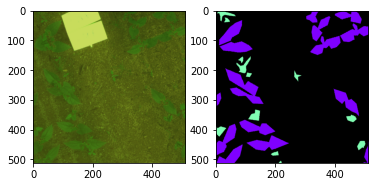

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

We install efficientnet in order to use it for transfer learning.

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

     |████████████████████████████████| 51kB 4.5MB/s 


Now we create the model. We use Imagenet weights but completely fine-tuned to recover the features useful on this task, and a decoder with transpose convolutions and with more dropout to balance the greater complexity of the net with respect to the case of the model without transfer learning.

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

def model():
    inputs = Input(shape=(img_h,img_w, 3), name="input_image")
    
    encoder = efn.EfficientNetB5(input_tensor=inputs, include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))
    skip_connection_names = ["input_image", "block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation"]
    encoder_output = encoder.get_layer("top_activation").output
    
    f = [16, 32, 64, 128, 128] 
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = Conv2DTranspose(f[-i], (2, 2), strides=(2, 2), padding='same')(x)
        x = Concatenate()([x, x_skip])
        x = BatchNormalization()(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)
        
    x = Conv2D(3, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 48) 1296        input_image[0][0]                
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

We define the meanIoU and compile the model.

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 

# learning rate
lr = 1e-3   # After some trials, we have found this lr to be good enough to train quickly 
            # without oscillating too much around the final solution
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

We add some callbacks:early stopping to stop overfit and the learning rate adapter to refine search for minima during training. Then we train the model. (Normally it stops much before 80 epochs).

In [ ]:
import os
from datetime import datetime

callbacks = []

# earlystopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', mode='max', patience=10,restore_best_weights=True)
callbacks.append(es_callback)
# learning rate adapter callback
LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_meanIoU', mode='max', factor=0.2, patience=4, verbose=1, min_delta=0.0001, cooldown=0)
callbacks.append(LR_adapter_callback)
    
model.fit(x=train_dataset,
          epochs=80,  
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks,
          verbose = 1) #We like to monitor the accuracy during training live ()

In order to converge more precisely we change the optimizer and we contiune the training using Adadelta instead of Adam.

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

We train the model with the same callbacks as before.

In [ ]:
import os
from datetime import datetime    
callbacks = []


# earlystopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', mode='max', patience=8,restore_best_weights=True)
callbacks.append(es_callback)
# learning rate adapter callback
LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_meanIoU', mode='max', factor=0.2, patience=3, verbose=1, min_delta=0.0001, cooldown=0)
callbacks.append(LR_adapter_callback)
    
model.fit(x=train_dataset,
          epochs=80,  
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks,
          verbose = 1) #We like to monitor the accuracy during training live ()

Now we make predictions on the test set and we create a json file with the results.
To apply our model to the test images we cut them in portion of size 512*512 and we apply the model to each portion. Not as in the other cases where we perform a reshape of the images to have the correct size.

In [ ]:
import os
import json
from os import listdir
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

submission_dict = {}

teams = ['Roseau','Bipbip','Pead','Weedelec']
plants = ['Haricot','Mais']

for team in teams:
  for plant in plants:
    test_dir = os.path.join('/content/Development_Dataset/Test_Dev', team, plant)
    img_folder_dir = os.path.join(test_dir, 'Images')
    imgs = listdir(img_folder_dir)
    imgs = [f[:-4] for f in imgs]
    for img_name in imgs:
      if team == 'Roseau':
        img = Image.open(os.path.join(test_dir, 'Images', img_name + '.png'))
      else:
        img = Image.open(os.path.join(test_dir, 'Images', img_name + '.jpg'))
      img_arraycomplete = np.array(img)
      print(img.size)
      original_size=img.size

      numtiles1=(original_size[1]//img_h)+1
      print(numtiles1)
      numtiles2=(original_size[0]//img_w)+1
      res1=(img_h*numtiles1-original_size[1])//(numtiles1-1)
      res2=(img_w*numtiles2-original_size[0])//(numtiles2-1)
      k=0
      mask_arr=np.empty(original_size[::-1])
      for i in range(0,numtiles1):
        for j in range(0,numtiles2):
          if i==numtiles1-1:
            dim1=[original_size[1]-img_h,original_size[1]]
          else:
            dim1=[i*(img_h-res1),i*(img_h-res1)+img_h]
          if j==numtiles2-1:
            dim2=[original_size[0]-img_w,original_size[0]]
          else:
            dim2=[j*(img_w-res2),j*(img_w-res2)+img_w]

          img_array=img_arraycomplete[dim1[0]:dim1[1],dim2[0]:dim2[1],:]
          
          out_sigmoid = model.predict(tf.expand_dims(img_array, axis=0))
          prediction = tf.argmax(out_sigmoid, -1) 
          mask_arr[dim1[0]:dim1[1],dim2[0]:dim2[1]]=prediction
          k=k+1

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = team  
      submission_dict[img_name]['crop'] = plant 
      submission_dict[img_name]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

# Finally, save the results into the submission.json file
with open('/content/drive/My Drive/submission.json', 'w') as f:
    json.dump(submission_dict, f)

(1227, 819)
2
(1227, 818)
2
(1227, 819)
2
(1228, 819)
2
(1227, 820)
2
(1227, 819)
2
(1226, 819)
2
(1227, 819)
2
(1228, 821)
2
(1227, 820)
2
(1227, 819)
2
(1226, 820)
2
(1226, 820)
2
(1227, 818)
2
(1226, 818)
2
(1227, 821)
2
(1226, 820)
2
(1227, 820)
2
(1225, 821)
2
(1227, 820)
2
(1227, 821)
2
(1226, 821)
2
(1226, 819)
2
(1227, 822)
2
(1227, 819)
2
(1227, 822)
2
(1220, 817)
2
(1227, 822)
2
(1226, 821)
2
(1227, 819)
2
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(2048, 1536)
4
(3280, 2464)
5
(3280, 2464)
5
(3280, 2464)
5
(3280, 2464)
5
(3280, 2464)
5
(3280, 2464)
5
(3280, 2464)
5
(3280, 2464)
5
(3280, 246

With this code we inspect also visually the goodnes of our predictions.

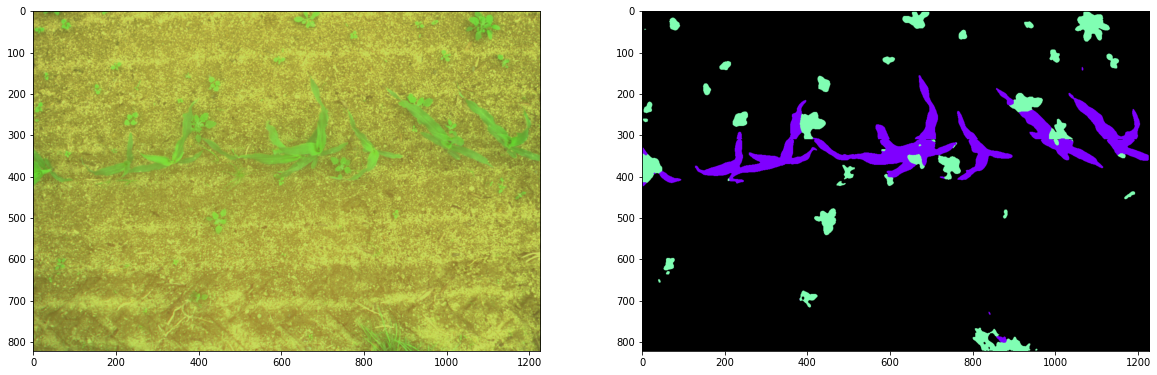

In [ ]:
# To visualize the predictions 
import os
import json
from os import listdir
import numpy as np
from PIL import Image

teams = 'Roseau'
plants = 'Mais'


test_dir = os.path.join('/content/Development_Dataset/Test_Dev', teams, plants)
img_folder_dir = os.path.join(test_dir, 'Images')
imgs = listdir(img_folder_dir)
imgs = [f[:-4] for f in imgs]
img_name = imgs[10]
if teams == 'Roseau':
  img = Image.open(os.path.join(test_dir, 'Images', img_name + '.png'))
else:
  img = Image.open(os.path.join(test_dir, 'Images', img_name + '.jpg'))
img_arraycomplete = np.array(img)
original_size=img.size

numtiles1=(original_size[1]//img_h)+1
numtiles2=(original_size[0]//img_w)+1
res1=(img_h*numtiles1-original_size[1])//(numtiles1-1)
res2=(img_w*numtiles2-original_size[0])//(numtiles2-1)
k=0
mask_arr=np.empty(original_size[::-1])
for i in range(0,numtiles1):
  for j in range(0,numtiles2):
    if i==numtiles1-1:
      dim1=[original_size[1]-img_h,original_size[1]]
    else:
      dim1=[i*(img_h-res1),i*(img_h-res1)+img_h]
    if j==numtiles2-1:
      dim2=[original_size[0]-img_w,original_size[0]]
    else:
      dim2=[j*(img_w-res2),j*(img_w-res2)+img_w]

    img_array=img_arraycomplete[dim1[0]:dim1[1],dim2[0]:dim2[1],:]
          
    out_sigmoid = model.predict(tf.expand_dims(img_array, axis=0))
    prediction = tf.argmax(out_sigmoid, -1) 
    mask_arr[dim1[0]:dim1[1],dim2[0]:dim2[1]]=prediction[0,:,:]
    k=k+1

target_img = np.zeros([mask_arr.shape[0], mask_arr.shape[1], 3])

target_img[np.where(mask_arr == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(mask_arr == i)] = np.array(colors[i-1])[:3] * 255
fig, ax = plt.subplots(1, 2,figsize=(20, 10))
ax[0].imshow(np.uint8(np.array(img)))
ax[1].imshow(np.uint8(target_img))





plt.show()